# Collaborative Filtering

In [1]:
import logging

from pprint import pprint

import matplotlib.pyplot as plt

# from fastai.basics import *
# from fastai.callback.all import *
# from fastai.torch_basics import *
# from fastai.data.all import *

from fastai.tabular.all import *
from fastai.collab import *

from fastai.collab import (EmbeddingDotBias, Learner, MSELossFlat, EarlyStoppingCallback, default_device)

import vaep
import vaep.model
import vaep.models as models
from vaep.models import plot_loss, RecorderDump

import vaep.nb
from vaep import sampling
from vaep.io import datasplits

from vaep.logging import setup_logger

# overwriting Recorder callback with custom plot_loss
from fastai import learner
learner.Recorder.plot_loss = plot_loss
# import fastai.callback.hook # Learner.summary


logger = setup_logger(logger=logging.getLogger('vaep'))
logger.info(
    "Experiment 03 - Analysis of latent spaces and performance comparisions")

figures = {}  # collection of ax or figures

vaep - INFO     Experiment 03 - Analysis of latent spaces and performance comparisions


Papermill script parameters:

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # change default to pickled files
# training
epochs_max: int = 20  # Maximum number of epochs
# early_stopping:bool = True # Wheather to use early stopping or not
patience: int = 1  # Patience for early stopping
batch_size: int = 32_768  # Batch size for training (and evaluation)
cuda: bool = True  # Use the GPU for training?
# model
# Dimensionality of encoding dimension (latent space of model)
latent_dim: int = 10
# hidden_layers:str = '128_64' # Underscore separated string of layers, '128 64' for the encoder, reversed for decoder
sample_idx_position: int = 0  # position of index which is sample ID
model: str = 'CF'  # model name
model_key: str = 'CF'  # potentially alternative key for model (grid search)
save_pred_real_na: bool = True  # Save all predictions for missing values

In [4]:
# Parameters
model = "CF"
file_format = "csv"
latent_dim = 50
batch_size = 4096
epochs_max = 20
sample_idx_position = 0
cuda = False
save_pred_real_na = True
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
folder_experiment = "runs/dev_dataset_small/proteinGroups_N50"
model_key = "CF"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/dev_dataset_small/proteinGroups_N50',
 'folder_data': '',
 'file_format': 'csv',
 'epochs_max': 20,
 'patience': 1,
 'batch_size': 4096,
 'cuda': False,
 'latent_dim': 50,
 'sample_idx_position': 0,
 'model': 'CF',
 'model_key': 'CF',
 'save_pred_real_na': True,
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'}

In [6]:
args = vaep.nb.args_from_dict(args)

# # Currently not needed -> DotProduct used, not a FNN
# if isinstance(args.hidden_layers, str):
#     args.overwrite_entry("hidden_layers", [int(x) for x in args.hidden_layers.split('_')])
# else:
#     raise ValueError(f"hidden_layers is of unknown type {type(args.hidden_layers)}")
args

{'batch_size': 4096,
 'cuda': False,
 'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'epochs_max': 20,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'latent_dim': 50,
 'model': 'CF',
 'model_key': 'CF',
 'out_figures': Path('runs/dev_dataset_small/proteinGroups_N50/figures'),
 'out_folder': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_metrics': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_models': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_preds': Path('runs/dev_dataset_small/proteinGroups_N50/preds'),
 'patience': 1,
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

if not args.cuda:
    default_device(use=False)  # set to cpu

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/dev_dataset_small/proteinGroups_N50/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X

Sample ID                                       Gene Names
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  AAAS         28.349
                                                AACS         26.133
                                                AAMP         26.777
                                                AAR2         27.248
                                                AARS         32.195
                                                              ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  ZNHIT2       26.946
                                                ZRANB2       28.098
                                                ZW10         29.425
                                                ZWINT        24.794
                                                ZYX          29.847
Name: intensity, Length: 167898, dtype: float64

In [10]:
# ! add check that specified data is available
# silent error in fastai if e.g. target column is not available

Infer index names from long format

In [11]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError(
        "More than one feature: Needs to be implemented. see above logging output.")

vaep - INFO     sample_id = 'Sample ID', single feature: index_column = 'Gene Names'


### Use some simulated missing for evaluation

The validation simulated NA is used to by all models to evaluate training performance.

In [12]:
val_pred_simulated_na = data.val_y.to_frame(name='observed')
val_pred_simulated_na

,,observed
Sample ID,Gene Names,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934
...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654


In [13]:
test_pred_simulated_na = data.test_y.to_frame(name='observed')
test_pred_simulated_na.describe()

,observed
count,"9,327.000"
mean,27.230
std,2.888
min,19.974
25%,24.905
50%,26.929
75%,29.174
max,37.689


## Collaborative Filtering

- save custom collab batch size (increase AE batch size by a factor), could be setup separately.
- the test data is used to evaluate the performance after training

In [14]:
# larger mini-batches speed up training
ana_collab = models.collab.CollabAnalysis(
    datasplits=data,
    sample_column=sample_id,
    item_column=index_column,  # not generic
    target_column='intensity',
    model_kwargs=dict(n_factors=args.latent_dim,
                      y_range=(int(data.train_X.min()),
                               int(data.train_X.max()) + 1)
                      ),
    batch_size=args.batch_size)

In [15]:
print("Args:")
pprint(ana_collab.model_kwargs)

Args:
{'n_factors': 50, 'y_range': (20, 40)}


In [16]:
ana_collab.model = EmbeddingDotBias.from_classes(
    classes=ana_collab.dls.classes,
    **ana_collab.model_kwargs)

args.n_params = models.calc_net_weight_count(ana_collab.model)
ana_collab.params['n_parameters'] = args.n_params
ana_collab.learn = Learner(dls=ana_collab.dls, model=ana_collab.model, loss_func=MSELossFlat(),
                           cbs=EarlyStoppingCallback(patience=args.patience),
                           model_dir=args.out_models)
if args.cuda:
    ana_collab.learn.model = ana_collab.learn.model.cuda()
else:
    # try to set explicitly cpu in case not cuda
    # MPS logic might not work properly in fastai yet https://github.com/fastai/fastai/pull/3858
    ana_collab.learn.model = ana_collab.learn.model.cpu()

# learn.summary() # see comment at DAE

### Training

suggested_lr.valley = 0.00525


epoch,train_loss,valid_loss,time
0,9.581757,15.023600,00:00
1,8.496699,10.430230,00:00
2,4.834772,1.714772,00:00
3,2.548378,1.179266,00:00
4,1.475653,0.951794,00:00
5,0.913969,0.815708,00:00
6,0.647666,0.774424,00:00
7,0.508874,0.766144,00:00
8,0.423161,0.745746,00:00
9,0.362035,0.742948,00:00


No improvement since epoch 11: early stopping


vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/collab_training


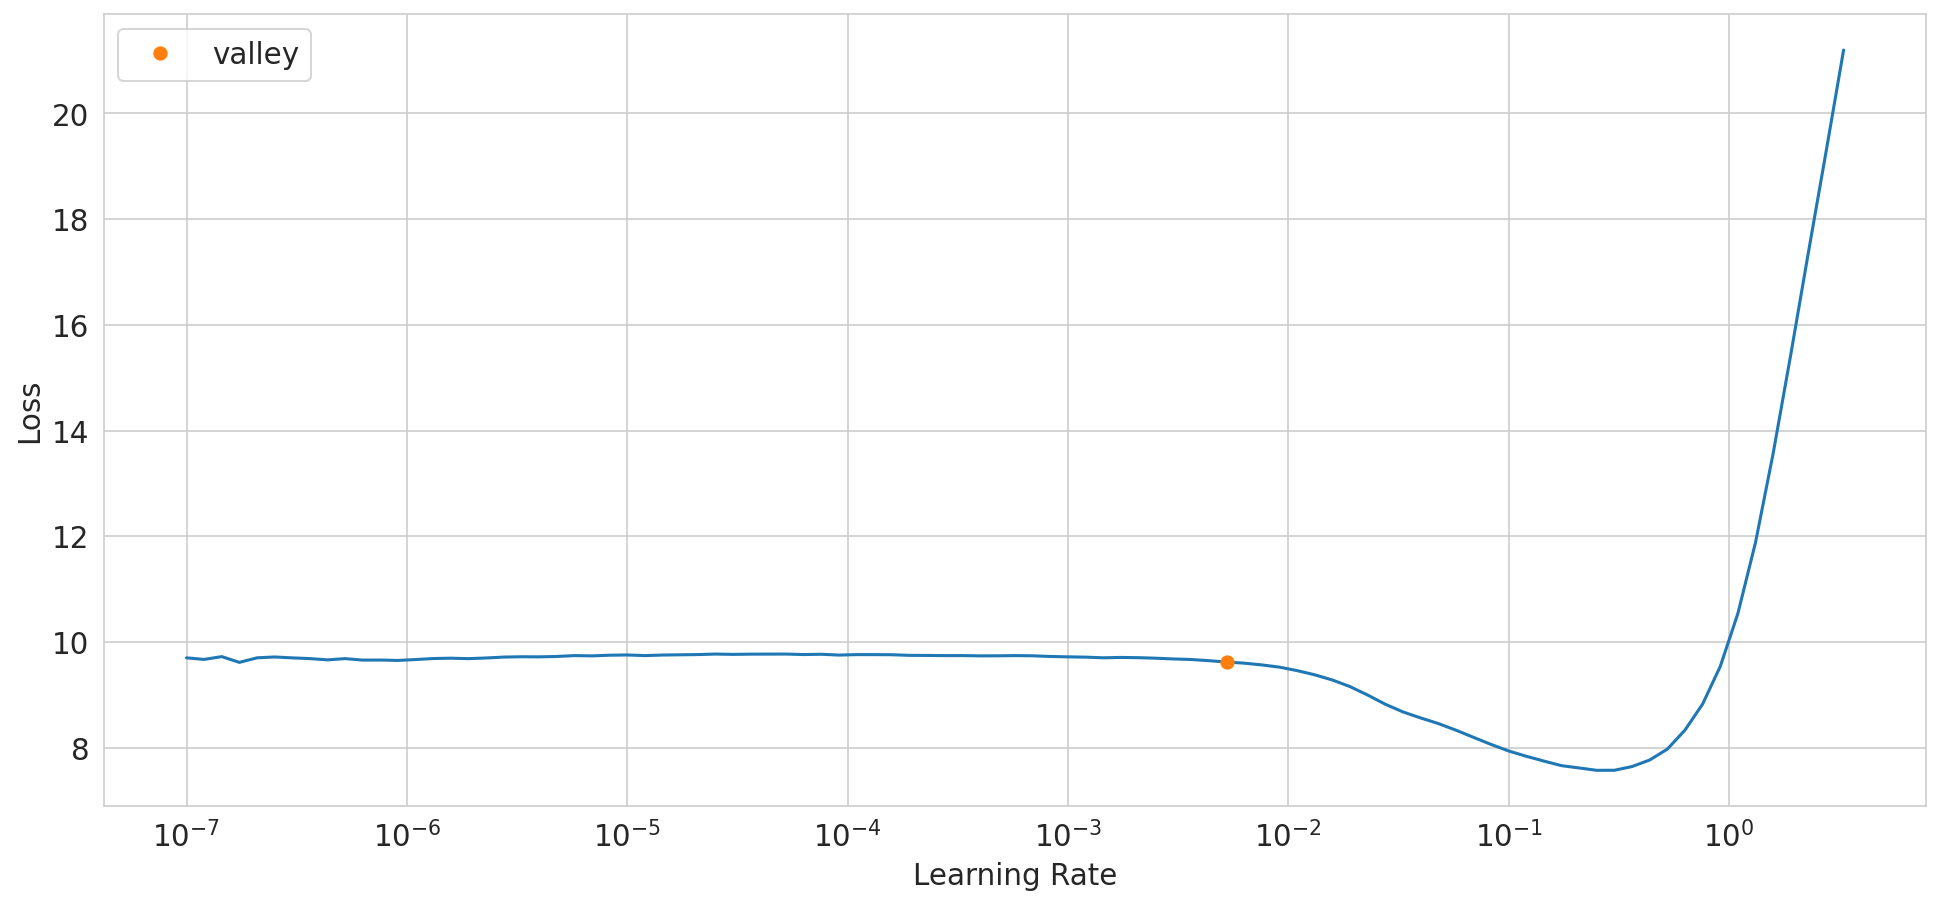

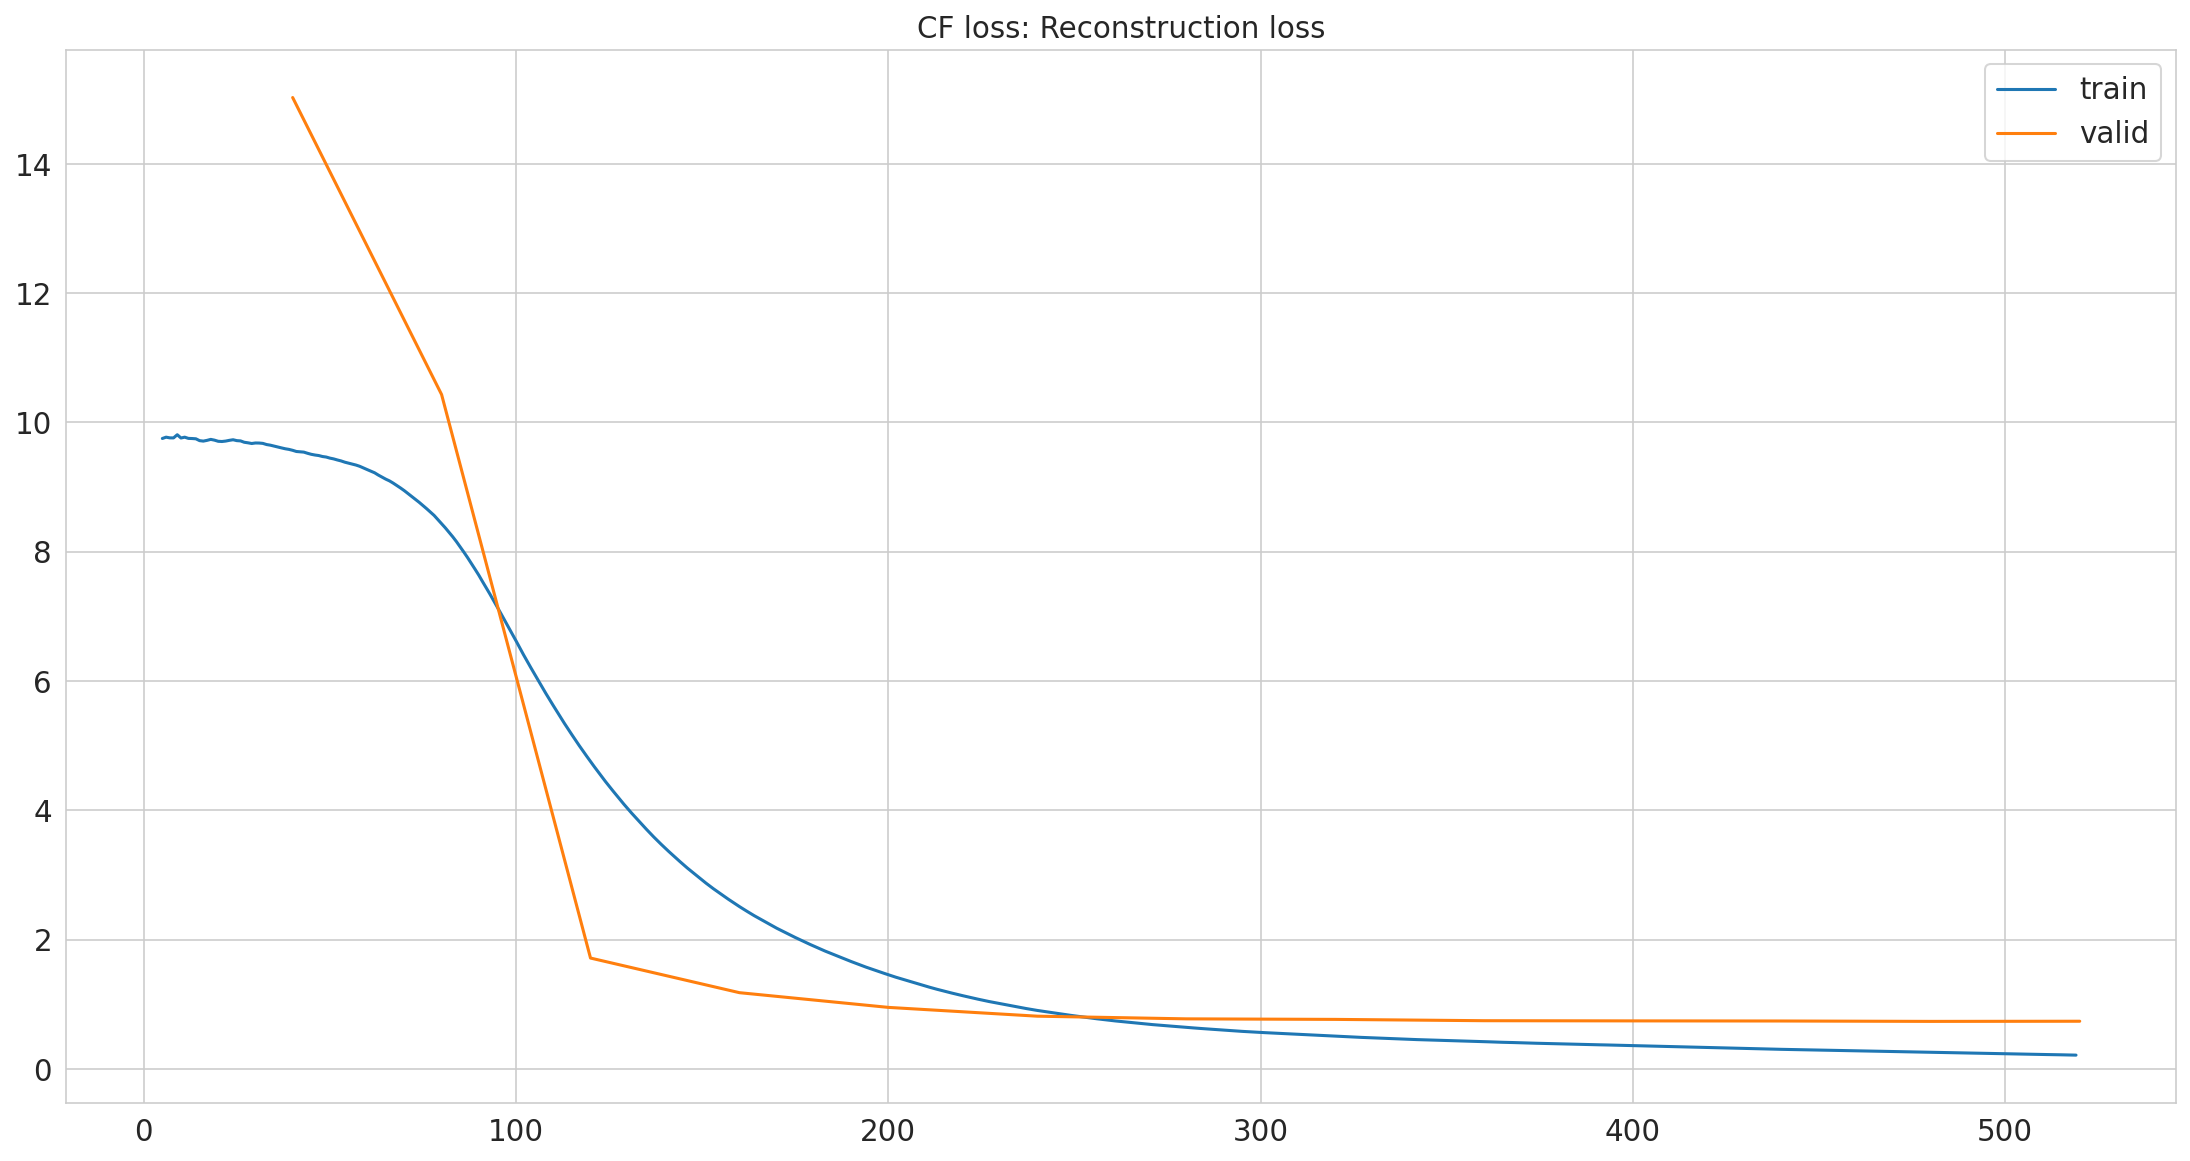

In [17]:
# papermill_description=train_collab
suggested_lr = ana_collab.learn.lr_find()
print(f"{suggested_lr.valley = :.5f}")
ana_collab.learn.fit_one_cycle(args.epochs_max, lr_max=suggested_lr.valley)
args.epoch_trained = ana_collab.learn.epoch + 1
# ana_collab.learn.fit_one_cycle(args.epochs_max, lr_max=1e-3)
ana_collab.model_kwargs['suggested_inital_lr'] = suggested_lr.valley
ana_collab.learn.save('collab_model')
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('CF loss: Reconstruction loss')
ana_collab.learn.recorder.plot_loss(skip_start=5, ax=ax)
recorder_dump = RecorderDump(
    recorder=ana_collab.learn.recorder, name='CF')
recorder_dump.save(args.out_figures)
del recorder_dump
vaep.savefig(fig, name='collab_training',
             folder=args.out_figures)
ana_collab.model_kwargs['batch_size'] = ana_collab.batch_size
vaep.io.dump_json(ana_collab.model_kwargs, args.out_models /
                  TEMPLATE_MODEL_PARAMS.format('CF'))

### Predictions

Compare simulated_na data predictions to original values

In [18]:
# this could be done using the validation data laoder now
ana_collab.test_dl = ana_collab.dls.test_dl(
    data.val_y.reset_index())  # test_dl is here validation data
val_pred_simulated_na['CF'], _ = ana_collab.learn.get_preds(
    dl=ana_collab.test_dl)
val_pred_simulated_na

,,observed,CF
Sample ID,Gene Names,,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180,26.583
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259,28.327
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629,30.793
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541,25.951
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934,33.588
...,...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717,28.328
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966,24.082
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654,24.776


select test data predictions

In [19]:
ana_collab.test_dl = ana_collab.dls.test_dl(data.test_y.reset_index())
test_pred_simulated_na['CF'], _ = ana_collab.learn.get_preds(dl=ana_collab.test_dl)
test_pred_simulated_na

observed  \
Sample ID                                      Gene Names                   
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1               29.538   
                                               ACTN4               33.270   
                                               ADD3                24.259   
                                               ALCAM               24.906   
                                               ALDH1B1             26.674   
...                                                                   ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3               25.040   
                                               YTHDF3              28.717   
                                               ZC3H11A             28.935   
                                               ZFP91-CNTF;ZFP91    25.662   
                                               hCG_2014768;TMA7    29.212   

                                                                    CF  
Sample ID                                      Gene Names               
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1            29.371  
                                               ACTN4            33.276  
                                               ADD3             24.798  
                                               ALCAM            24.213  
                                               ALDH1B1          27.334  
...                                                                ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3            25.568  
                                               YTHDF3           27.812  
                                               ZC3H11A          29.216  
                                               ZFP91-CNTF;ZFP91 26.509  
                                               hCG_2014768;TMA7 28.602  

[9327 rows x 2 columns]

In [20]:
if args.save_pred_real_na:
    pred_real_na = models.collab.get_missing_values(
        df_train_long=data.train_X,
        val_idx=data.val_y.index,
        test_idx=data.test_y.index,
        analysis_collab=ana_collab)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

## Data in wide format

- Autoencoder need data in wide format

In [21]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB10,...,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,28.349,26.133,NaN,26.777,27.248,32.195,27.153,27.872,28.603,26.110,...,NaN,NaN,28.309,28.831,28.851,NaN,24.379,29.427,28.080,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.657,25.019,24.236,26.271,NaN,NaN,26.530,28.191,27.942,25.735,...,NaN,NaN,28.133,27.267,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,28.352,23.740,NaN,27.098,27.377,32.885,27.515,28.476,28.771,26.787,...,25.184,NaN,28.968,27.322,29.388,NaN,25.803,29.525,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,26.826,NaN,NaN,NaN,NaN,31.926,26.157,27.635,27.851,25.346,...,NaN,23.586,NaN,27.278,28.076,NaN,24.688,28.783,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,27.404,26.948,23.864,26.982,26.520,31.844,25.342,27.416,27.474,NaN,...,24.591,NaN,25.838,29.326,27.491,26.406,NaN,30.422,NaN,26.939


### Validation data

- all measured (identified, observed) peptides in validation data

> Does not make to much sense to compare collab and AEs,
> as the setup differs of training and validation data differs

In [22]:
# papermill_description=metrics
d_metrics = models.Metrics()

The simulated NA for the validation step are real test data (not used for training nor early stopping)

In [23]:
added_metrics = d_metrics.add_metrics(val_pred_simulated_na, 'valid_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'CF': {'MSE': 0.7375331737491456,
  'MAE': 0.5903760704601836,
  'N': 9327,
  'prop': 1.0}}

### Test Datasplit

Simulated NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

In [24]:
added_metrics = d_metrics.add_metrics(test_pred_simulated_na, 'test_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'CF': {'MSE': 0.758842736222958,
  'MAE': 0.590720828169534,
  'N': 9327,
  'prop': 1.0}}

Save all metrics as json

In [25]:
vaep.io.dump_json(d_metrics.metrics, args.out_metrics /
                  f'metrics_{args.model_key}.json')

In [26]:
metrics_df = models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset             valid_simulated_na  test_simulated_na
model metric_name                                       
CF    MSE                       0.738              0.759
      MAE                       0.590              0.591
      N                     9,327.000          9,327.000
      prop                      1.000              1.000

## Save predictions

In [27]:
# save simulated missing values for both splits
val_pred_simulated_na.to_csv(args.out_preds / f"pred_val_{args.model_key}.csv")
test_pred_simulated_na.to_csv(args.out_preds / f"pred_test_{args.model_key}.csv")

## Config

In [28]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 4405,
 'batch_size': 4096,
 'cuda': False,
 'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'epoch_trained': 13,
 'epochs_max': 20,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'latent_dim': 50,
 'model': 'CF',
 'model_key': 'CF',
 'n_params': 227307,
 'out_figures': Path('runs/dev_dataset_small/proteinGroups_N50/figures'),
 'out_folder': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_metrics': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_models': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_preds': Path('runs/dev_dataset_small/proteinGroups_N50/preds'),
 'patience': 1,
 'sample_idx_position': 0,
 'save_pred_real_na': True}